### Import Useful Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
from google.colab import drive

!pip install contractions
import contractions
pd.options.mode.chained_assignment = None

start_time = time.time()
drive.mount('/content/drive')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Init EDA steps

#### Retrieve and display data

> Dataset is made up of the text of 10% of questions and answers from the Stack Overflow programming Q&A website.



In [2]:
questions_path = '/content/drive/MyDrive/Satori Assignment/data/Questions.csv'
tags_path = '/content/drive/MyDrive/Satori Assignment/data/Tags.csv'

try:
    questions_df = pd.read_csv(questions_path, encoding='utf-8')
except UnicodeDecodeError:
    questions_df = pd.read_csv(questions_path, encoding='latin1')

try:
    tags_df = pd.read_csv(tags_path, encoding='utf-8')
except UnicodeDecodeError:
    tags_df = pd.read_csv(tags_path, encoding='latin1')

In [3]:
display(questions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


None

> Fill tha NaN values with a space, in order to avoid future errors on merging.

In [4]:
questions_df.fillna(' ', inplace=True)
display(questions_df.head())

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [5]:
display(tags_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


None

> Note that for the same Id we have 1 or **more** Tags, meaning that we must compress this type of info (Multilabel Classification Case).

In [6]:
display(tags_df.head())

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


#### Merge dataframes (plus aggregation)

> Our merged dataframe (based on Id) is comprised of rows with **unique** Id and each relative Tag(s).

In [7]:
tags_df['Tag'] = tags_df['Tag'].astype(str)
merged_df = pd.merge(questions_df, tags_df, how='inner', on='Id')
merged_df = merged_df.groupby(['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title', 'Body']).agg({'Tag': lambda x: ', '.join(x)}).reset_index()
merged_df['Tag'] = merged_df['Tag'].apply(lambda x: x.split(', '))
merged_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,80,26.0,2008-08-01T13:57:07Z,,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,83.0,2008-08-01T15:50:08Z,,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,180,2089740.0,2008-08-01T18:42:19Z,,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,260,91.0,2008-08-01T23:22:08Z,,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


In [8]:
print('Number of training examples:', merged_df.shape[0])

Number of training examples: 1264216


In [9]:
duplicates = merged_df[merged_df.duplicated(subset=['Id'], keep=False)]
if duplicates.empty == False: print('Error: Found duplicate row!')

#### Explore Score and Dates

##### Score

In [10]:
merged_df['Score'].describe()

count    1.264216e+06
mean     1.781537e+00
std      1.366389e+01
min     -7.300000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      5.190000e+03
Name: Score, dtype: float64

In [11]:
print('Only ' + str((merged_df['Score']<0).sum()) + ' questions have negative Score.')
print('Only ' + str((merged_df['Score']==0).sum()) + ' questions have zero Score.')
print('Only ' + str((merged_df['Score']>0).sum()) + ' questions have positive Score.')
print('Only ' + str((merged_df['Score']>5).sum()) + ' questions have Score greater than 5.')

Only 78449 questions have negative Score.
Only 591710 questions have zero Score.
Only 594057 questions have positive Score.
Only 72950 questions have Score greater than 5.


> Half data have zero Score and the other roughly half a non-zero positive Score. Keep in mind that approximately only 6% contain Score greater than 5.


> **Negative Score**: A negative Score on a Stack Overflow question typically indicates that it has received **more** downvotes than upvotes. This typically happens when question may be poorly written, not relevant to the topic, duplicate question or too trivial to be answered, lack of researching. Generally the community has deemed the question to be of low quality and shows dissatisfaction.

> **Zero Score**: A zero Score on Stack Overflow question often indicates a neutral stance from the readers, where number of upvotes are equal with downvotes, or possibly no vote at all. This signifies, mixed feedback regarding the question's quality or general relevance.

> **Positive Score**: A positive Score question demonstrates its value and usefulness to the community. This kind of questions, most of the times provide valuable insights, solutions and well-explained hints that address challenges.  

> That being said, we could experiment to retrieve only the questions that contain as much quality as possible. For example, we could start by grasping only positive Score questions. Hoping that positive Scores could indicate higher-quality questions that are more likely to be associated with relevant tags.


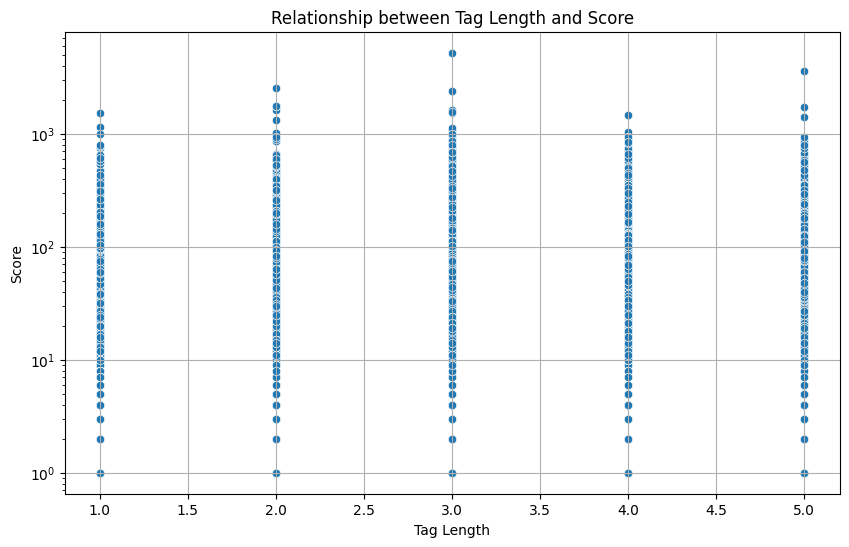

In [12]:
merged_df['Tag_Length'] = merged_df['Tag'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tag_Length', y='Score', data=merged_df)
plt.yscale('log')
plt.title('Relationship between Tag Length and Score')
plt.xlabel('Tag Length')
plt.ylabel('Score')
plt.grid(True)
plt.show()

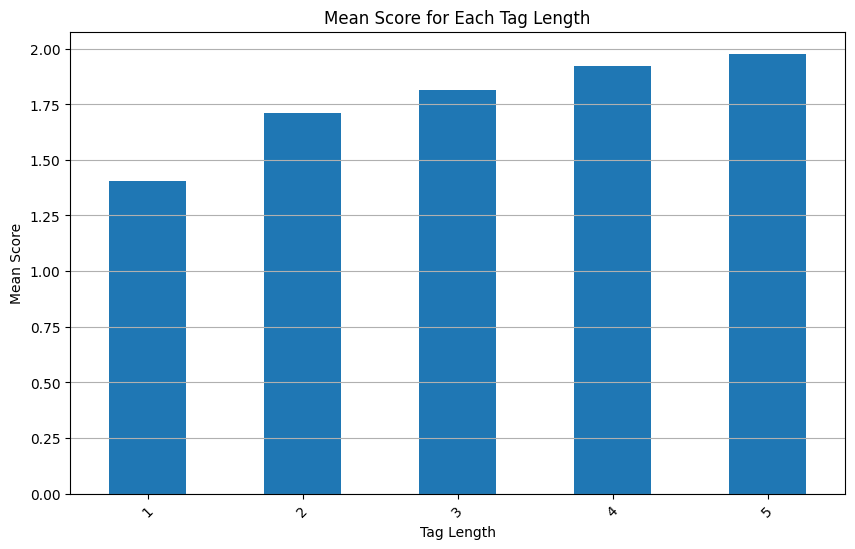

In [13]:
mean_scores = merged_df.groupby('Tag_Length')['Score'].mean()

plt.figure(figsize=(10, 6))
mean_scores.plot(kind='bar')
plt.title('Mean Score for Each Tag Length')
plt.xlabel('Tag Length')
plt.ylabel('Mean Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

> Slightly the score increases when we have a bigger number of tags.

##### Creation and Closed Dates

In [14]:
print('Only ' + str((merged_df['ClosedDate']!=' ').sum()) + ' questions contain Closed Date.')

Only 55959 questions contain Closed Date.


> About 4% of all training examples have a nonnan value as ClosedDate.

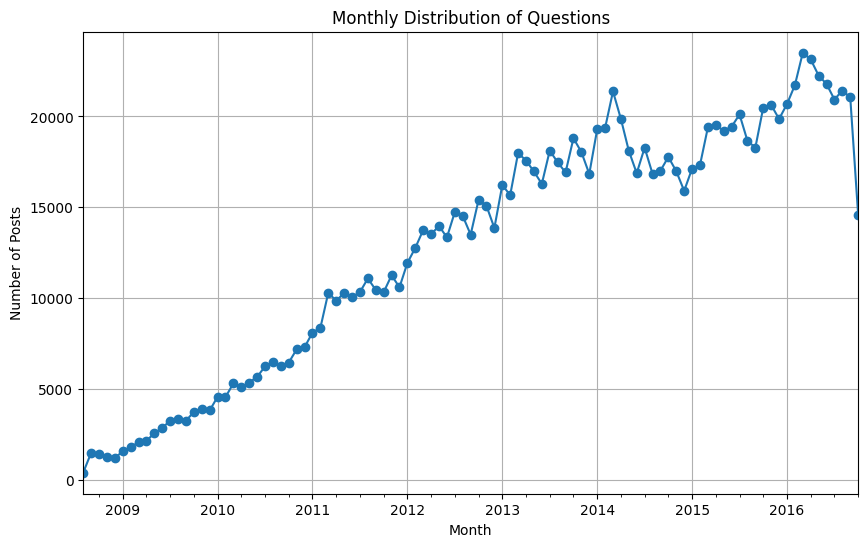

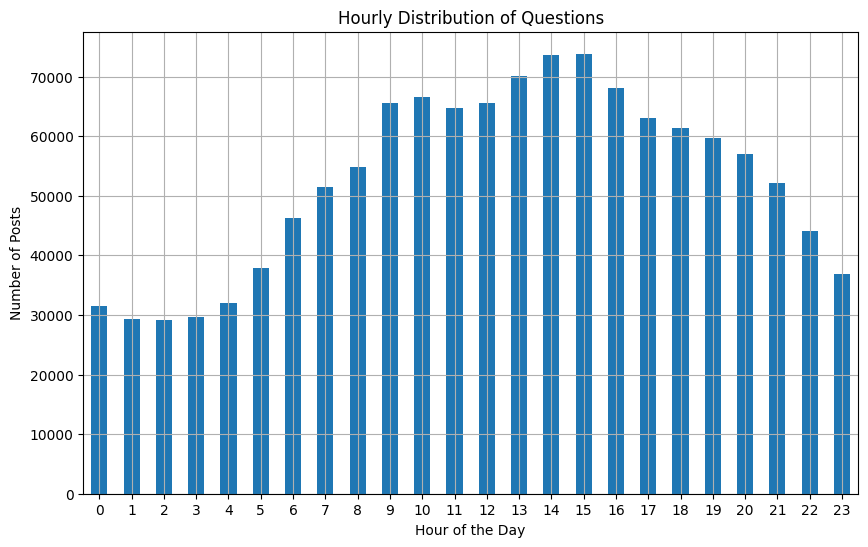

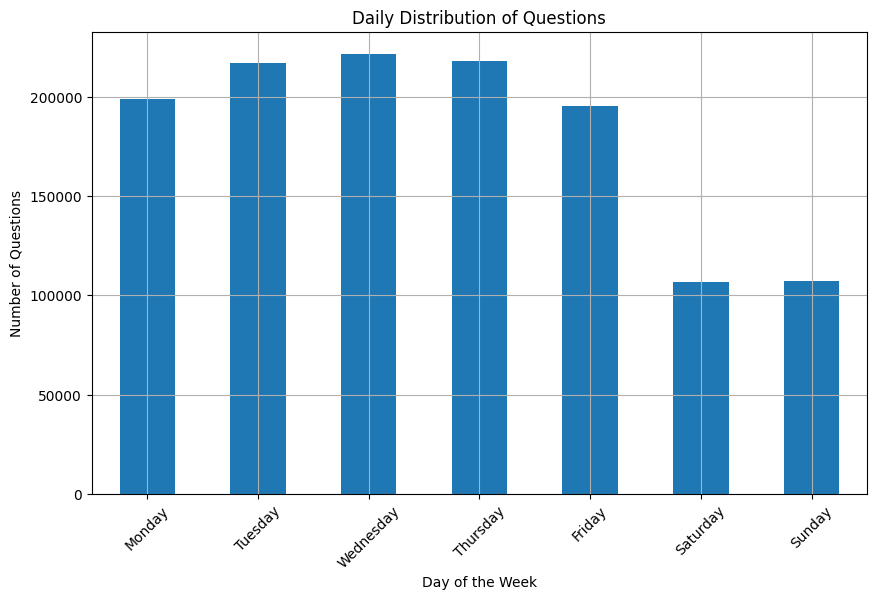

In [15]:
merged_df['CreationDate'] = pd.to_datetime(merged_df['CreationDate'])

monthly_counts = merged_df.resample('M', on='CreationDate').size()
monthly_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Monthly Distribution of Questions')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

hourly_counts = merged_df.groupby(merged_df['CreationDate'].dt.hour).size()
hourly_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Hourly Distribution of Questions')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

daily_counts = merged_df.groupby(merged_df['CreationDate'].dt.dayofweek).size()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts.index = days
daily_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Daily Distribution of Questions')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

> StackOverflow gain more popular across the years.

> StackOverflow busy moments are when most of people working, specifically working days between 09:00-17:00 generally.

#### Explore Tags

##### Tag Frequency

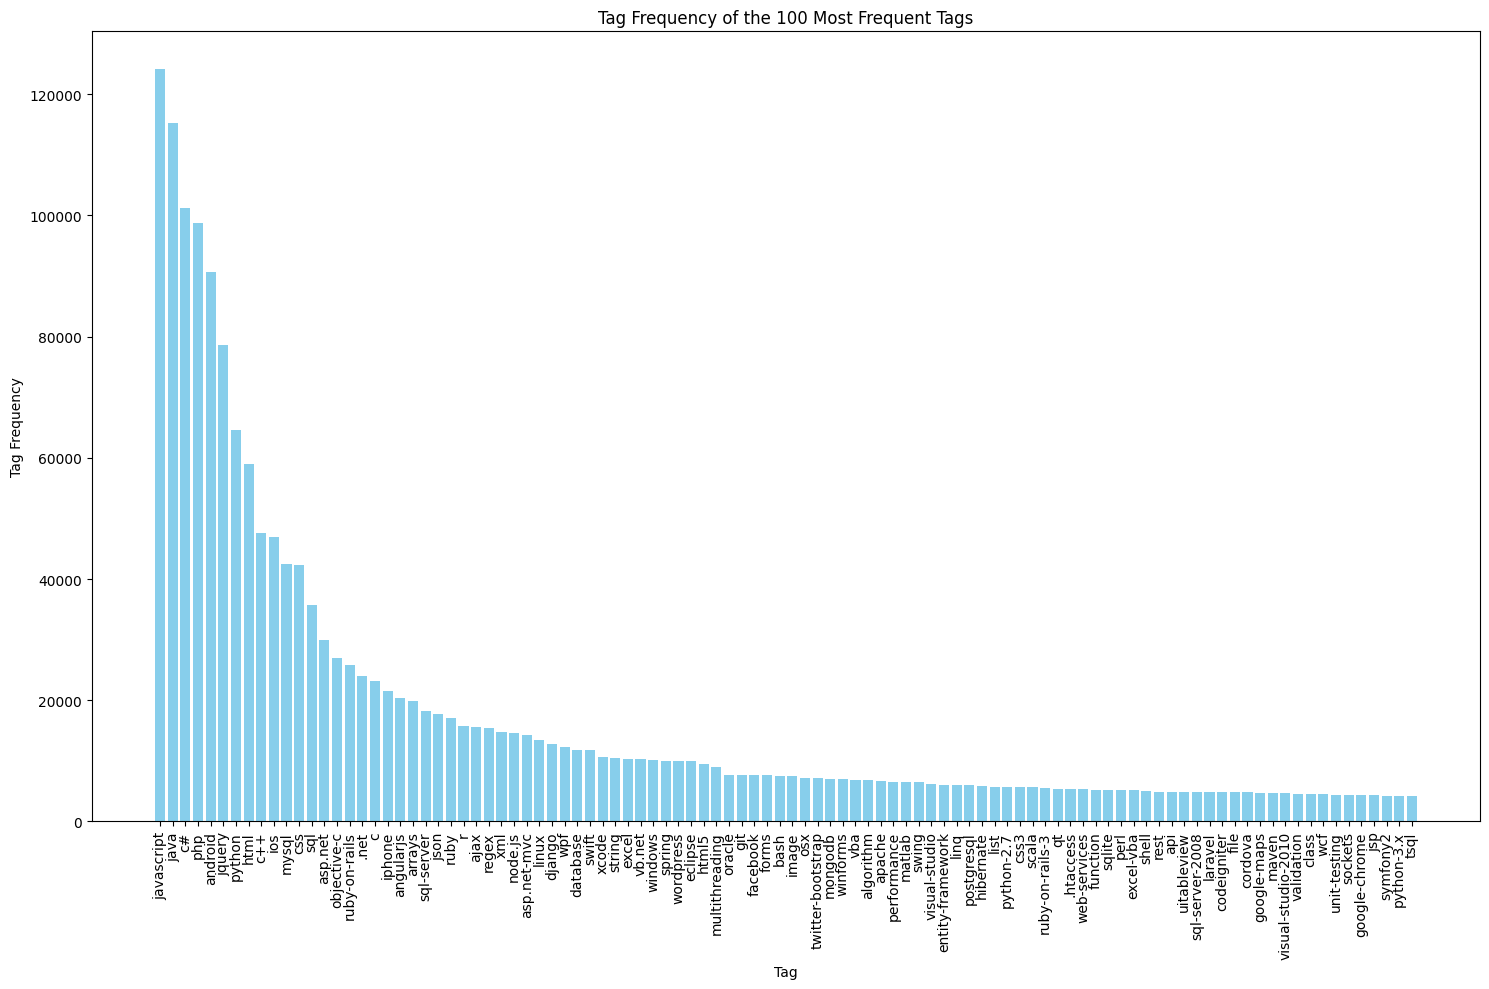

In [16]:
N = 100
tag_frequencies = tags_df['Tag'].value_counts().head(N)

plt.figure(figsize=(15, 10))
plt.bar(tag_frequencies.index, tag_frequencies, color='skyblue')
plt.xlabel('Tag')
plt.ylabel('Tag Frequency')
plt.title('Tag Frequency of the {} Most Frequent Tags'.format(N))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

> * Javascript, Java and C# appear as Tag more than 100.000 times.
* 5 Tags are used more than 80.000 times.
* 17 Tags are used more than 20.000 times.



##### WordCloud

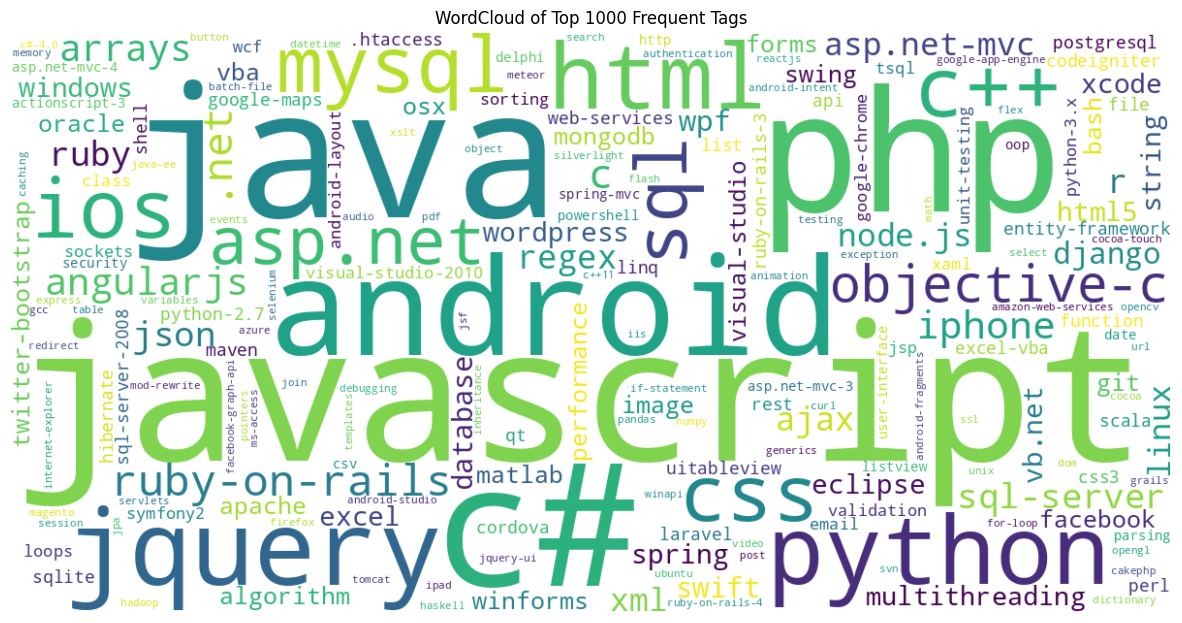

In [17]:
tag_frequencies = tags_df['Tag'].value_counts()
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(tag_frequencies.head(1000))

plt.figure(figsize=(15, 10))
plt.title('WordCloud of Top 1000 Frequent Tags')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

> Majority of the most frequent tags are programming languages, Javascript is leading the race. Also, Android, IOS, Linux are among the top most frequent operating systems.




##### Questions Number of Tags Frequency

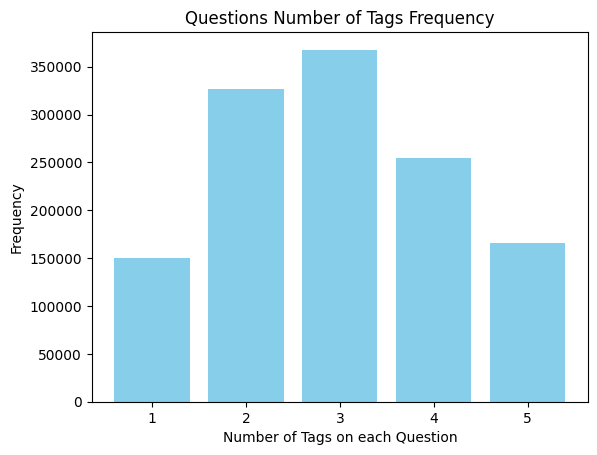

In [18]:
statistics = merged_df['Tag_Length'].value_counts().sort_index()

plt.bar(statistics.index, statistics.values, color='skyblue')
plt.xlabel('Number of Tags on each Question')
plt.ylabel('Frequency')
plt.title('Questions Number of Tags Frequency')
plt.xticks(statistics.index)
plt.show()

In [19]:
print('The Average Number of Tags per Question is',"{:.2f}".format(sum(merged_df['Tag_Length'].values)*1.0/(len(merged_df['Tag_Length'].values)),2), 'tags')

The Average Number of Tags per Question is 2.97 tags


> So, the biggest percent of our Questions contain 2-3 Tags.

##### Coverage of Top N Tags against all Tags

In [20]:
total_unique_tags = len(tags_df['Tag'].unique())
print("Total Unique Tags:", total_unique_tags)

Total Unique Tags: 37035


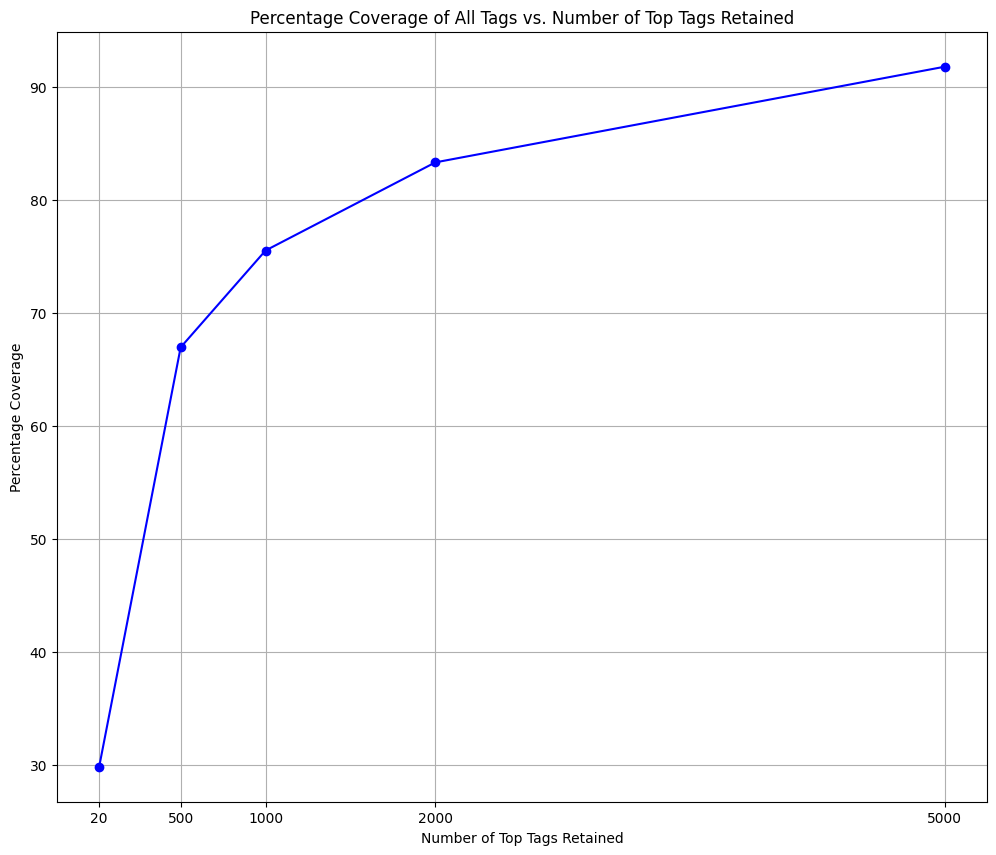

In [21]:
tag_frequencies = tags_df['Tag'].value_counts()
N_values = [20,500,1000,2000,5000]

coverage_values = []
total_entries = len(tags_df)
for N in N_values:
    top_N_tags = tag_frequencies.head(N)
    total_frequency = top_N_tags.sum()
    coverage = (total_frequency / total_entries) * 100
    coverage_values.append(coverage)

plt.figure(figsize=(12, 10))
plt.plot(N_values, coverage_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Top Tags Retained')
plt.ylabel('Percentage Coverage')
plt.title('Percentage Coverage of All Tags vs. Number of Top Tags Retained')
plt.grid(True)
plt.xticks(N_values)
plt.show()

> So the total number of unique Tags is approximately 37.000. In the above figure, we conclude that if we retain only the top **20 Tags** then we have covered approximately **30%** of all Tags from Tags dataframe. Whereas with the top **5.000 Tags** we gain something better than **91%** of all Tags from Tags dataframe.

##### Coverage of Questions if we retain Top N Tags

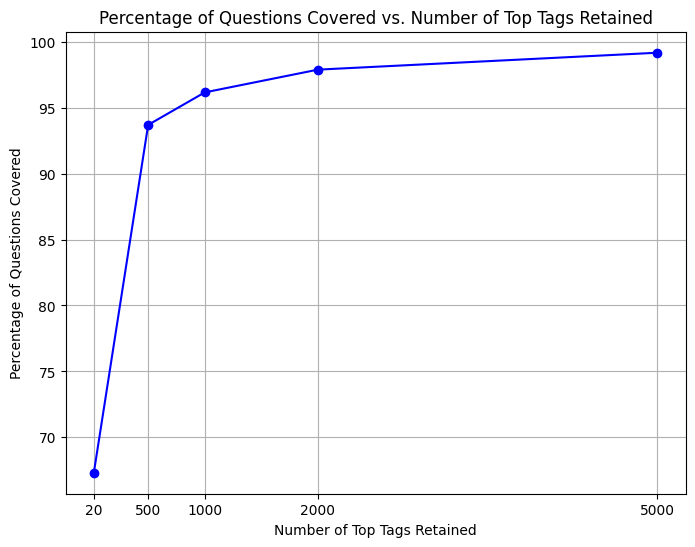

In [22]:
questions_coverage = []
total_questions = len(merged_df)

for N in N_values:
    top_N_tags = tag_frequencies.head(N).index.tolist()
    # Filter to include only questions with top N tags
    filtered_df = merged_df[merged_df['Tag'].apply(lambda x: any(tag in x for tag in top_N_tags))]

    unique_questions = filtered_df['Id'].nunique()
    coverage_percentage = (unique_questions / total_questions) * 100
    questions_coverage.append(coverage_percentage)

plt.figure(figsize=(8, 6))
plt.plot(N_values, questions_coverage, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Top Tags Retained')
plt.ylabel('Percentage of Questions Covered')
plt.title('Percentage of Questions Covered vs. Number of Top Tags Retained')
plt.grid(True)
plt.xticks(N_values)
plt.show()

> We notice that with top **20 Tags** we cover the massive percentage **88%** of all StackOverflow Questions.

### Preprocessing

#### Subset of Original Data

##### Positive Score Questions

> Due to memory, time and computational resources we are going to retain the most quality Questions with positive Score (we've being experimented also with only retaining non negative Score Questions).

In [23]:
merged_df = merged_df[merged_df['Score'] > 0]
print('Number of Questions with positive Score:', merged_df.shape[0])

Number of Questions with positive Score: 594057


In [24]:
merged_df

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag,Tag_Length
0,80,26.0,2008-08-01 13:57:07+00:00,,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",3
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",4
2,120,83.0,2008-08-01 15:50:08+00:00,,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",3
3,180,2089740.0,2008-08-01 18:42:19+00:00,,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",4
4,260,91.0,2008-08-01 23:22:08+00:00,,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",4
...,...,...,...,...,...,...,...,...,...
1264164,40142110,1102835.0,2016-10-19 21:52:30+00:00,,1,Gradle parent and sub-projects as siblings,"<p>In a gradle multi-module project, can the p...",[gradle],1
1264198,40142870,2472888.0,2016-10-19 23:01:59+00:00,,1,MVC Remote validation is not rendering,<p>I have a model called ItemCodeModel that is...,"[c#, asp.net-mvc, remote-validation]",3
1264205,40143070,1031791.0,2016-10-19 23:23:31+00:00,,6,What exactly makes a type system consistent?,"<p>I've taken AndrÃ¡s KovÃ¡cs's <a href=""https...","[haskell, types, functional-programming, agda,...",5
1264210,40143190,333403.0,2016-10-19 23:36:01+00:00,,1,How to execute multiline python code from a ba...,<p>I need to extend a shell script (bash). As ...,"[python, bash, multiline]",3


##### Most Frequent Tag Combinations

In [25]:
merged_df['Tag'] = merged_df['Tag'].apply(sorted)
merged_df['Tag_Tuple'] = merged_df['Tag'].apply(tuple)
tag_combinations = merged_df.groupby('Tag_Tuple').size().reset_index(name='Count')
tag_combinations = tag_combinations.sort_values(by='Count', ascending=False)
tag_combinations

,Tag_Tuple,Count
34913,"(android,)",3630
308075,"(javascript, jquery)",2700
298425,"(java,)",2519
307857,"(javascript,)",2501
342652,"(php,)",2190
...,...,...
126142,"(c, linked-list, tree)",1
126140,"(c, linked-list, stack, struct, visual-studio-...",1
126139,"(c, linked-list, stack)",1
126138,"(c, linked-list, sorting, struct)",1


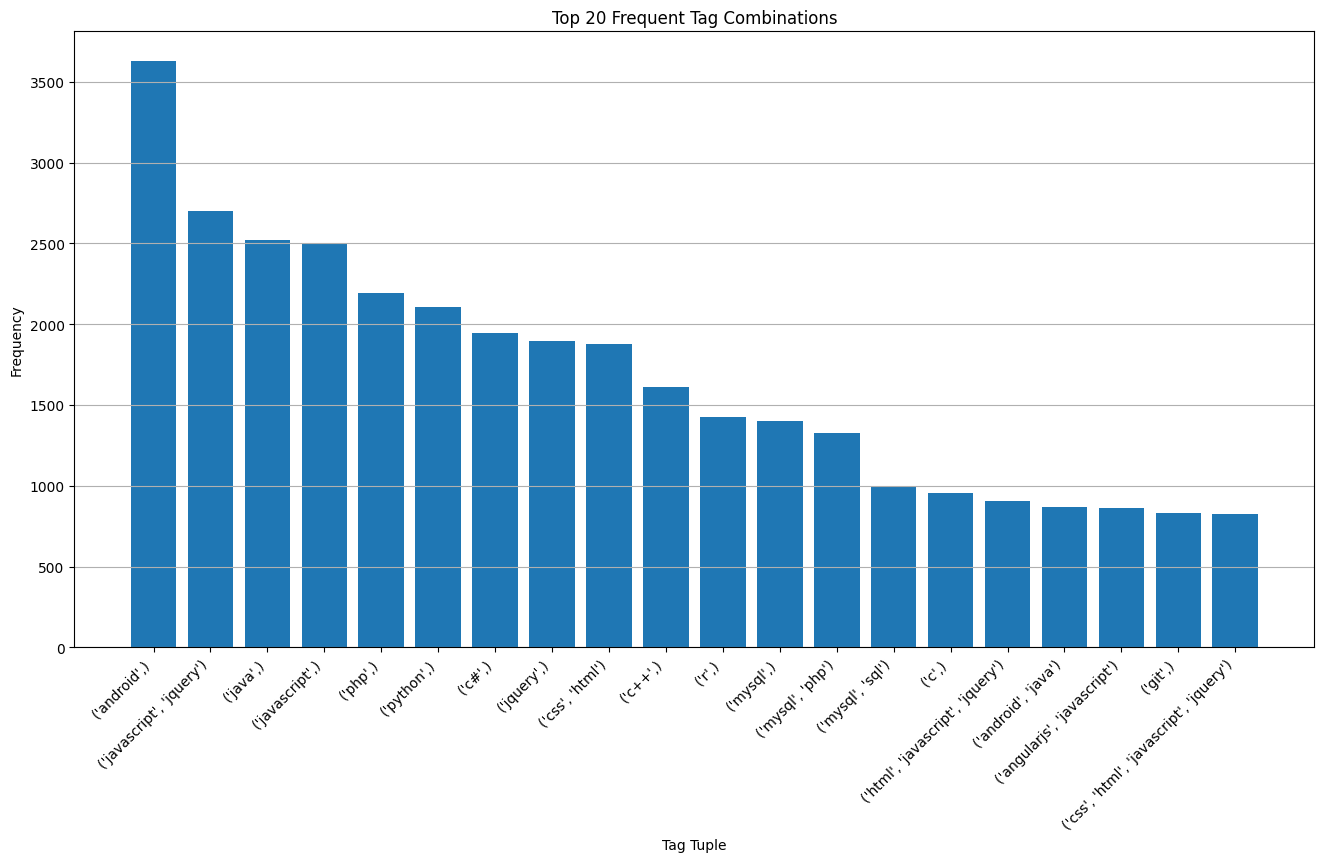

In [26]:
F = 20
top_F_df = tag_combinations.head(F).copy()
top_F_df['Tag_Tuple_str'] = top_F_df['Tag_Tuple'].astype(str)

plt.figure(figsize=(16, 8))
plt.bar(top_F_df['Tag_Tuple_str'], top_F_df['Count'])
plt.title(f'Top {F} Frequent Tag Combinations')
plt.xlabel('Tag Tuple')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

In [27]:
max = 20
top_tag_combinations = tag_combinations.head(max)
sum_count = top_tag_combinations['Count'].sum()
all_tags = [tag for tag_tuple in top_tag_combinations['Tag_Tuple'] for tag in tag_tuple]
num_unique_tags = len(set(all_tags))

print(f"Number of Questions of Top {max} Tag Combinations: {sum_count}")
print(f"Number of unique tags of Top {max} Tag Combinations: {num_unique_tags}")
print(f"Minimum Frequency of Top {max} Tag Combinations: {top_tag_combinations['Count'].iloc[-1]}\n")

top_tag_combinations

Number of Questions of Top 20 Tag Combinations: 33374
Number of unique tags of Top 20 Tag Combinations: 16
Minimum Frequency of Top 20 Tag Combinations: 823



,Tag_Tuple,Count
34913,"(android,)",3630
308075,"(javascript, jquery)",2700
298425,"(java,)",2519
307857,"(javascript,)",2501
342652,"(php,)",2190
347620,"(python,)",2109
127875,"(c#,)",1944
314405,"(jquery,)",1898
195989,"(css, html)",1879
145456,"(c++,)",1608


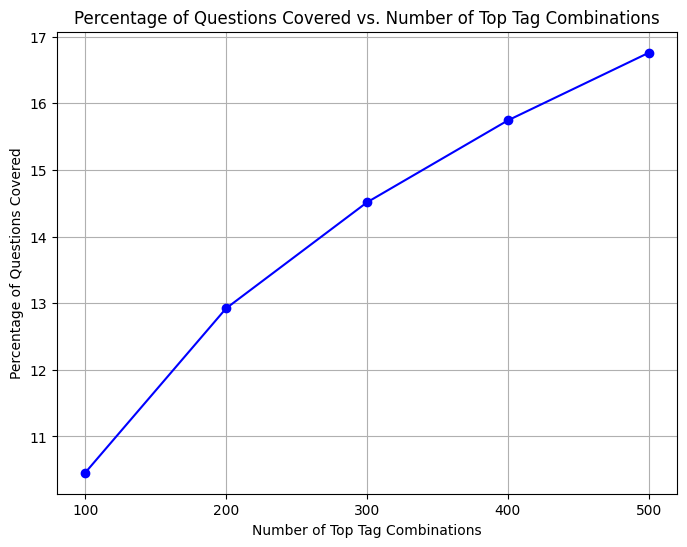

In [28]:
questions_coverage = []
total_questions = len(merged_df)
D_values = range(100,600,100)

for D in D_values:
    top_D_tags_count = tag_combinations.head(D)['Count'].sum()
    coverage_percentage = (top_D_tags_count / total_questions) * 100
    questions_coverage.append(coverage_percentage)

plt.figure(figsize=(8, 6))
plt.plot(D_values, questions_coverage, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Top Tag Combinations')
plt.ylabel('Percentage of Questions Covered')
plt.title('Percentage of Questions Covered vs. Number of Top Tag Combinations')
plt.grid(True)
plt.xticks(D_values)
plt.show()

> It may be easier for a model to capture the patterns with smaller number of Tags, but considering time and resources constraints (model training), it was vital to prune in some way our dataset and keeping the most frequent tags will lead our model perform better. We try to retain the most quality entries (positive Score Questions) and tag combinations with a sufficient amount of frequency.

In [29]:
top_tag_tuples = set(top_tag_combinations['Tag_Tuple'])
merged_df = merged_df[merged_df['Tag_Tuple'].apply(lambda x: x in top_tag_tuples)]

##### Give emphasis on Title


> In final dataframe we are going to retain:
*   **Text**: concatenation of 'Title' and 'Body' columns
*   **Tag**: respective list of Tag(s)


> Title usually contains super important words (i.e tags), so add Title more than once.

In [30]:
P = 3
merged_df['Text'] = (merged_df['Title'] + " ") * P + merged_df['Body']
final_df = merged_df[['Text', 'Tag']].copy()
display(final_df.head(6))

,Text,Tag
34,MySQL/Apache Error in PHP MySQL query MySQL/Ap...,"[mysql, php]"
135,How to setup site-wide variables in php? How t...,[php]
192,Select ..... where .... OR Select ..... where...,[mysql]
195,What Comes After The %? What Comes After The %...,[c]
205,Code to ask yes/no question in javascript Code...,[javascript]
207,Best way to keep an ordered list of windows (f...,[javascript]


In [31]:
def calculate_unique_tags(temp_df):
    all_tags = [tag for tags_list in temp_df['Tag'] for tag in tags_list]
    total_unique_tags = len(set(all_tags))
    print("Total number of unique tags:", total_unique_tags)

calculate_unique_tags(final_df)
print('Number of Questions:', final_df.shape[0])

Total number of unique tags: 16
Number of Questions: 33374


Print some random Question examples

In [32]:
pd.set_option('display.max_colwidth', None)
display(final_df.sample(1)['Text'])

241944    Git partial commit of staged changes Git partial commit of staged changes Git partial commit of staged changes <p>My current <code>git status</code> looks like this:</p>\n\n<pre><code># Changes to be committed:\n#   (use "git reset HEAD &lt;file&gt;..." to unstage)\n#\n#       modified:   docs/file3.org\n#       modified:   src/main/R/lib.R\n#\n# Changes not staged for commit:\n#   (use "git add &lt;file&gt;..." to update what will be committed)\n#   (use "git checkout -- &lt;file&gt;..." to discard changes in working directory)\n#\n#       modified:   docs/file3.org\n#       modified:   src/main/R/lib.R\n</code></pre>\n\n<p>I'd like to commit the <em>staged</em> changes to <code>docs/file3.org</code> first, then the other staged changes.  But if I do <code>git commit -m '...' docs/file3.org</code>, it will commit both the staged &amp; unstaged changes to that file.</p>\n\n<p>Is there an easy way to do this?  Or do I need to <code>stash</code> my unstaged changes, unstage one

#### Preprocessing pipeline

In [33]:
def replace_word_starting_with(text, prefixes):
    words = text.split()
    for i in range(len(words)):
        if words[i].startswith('javascript'):
            words[i] = 'javascript'
        if words[i].startswith('c++'):
            words[i] = 'c++'
        if words[i].startswith('c#'):
            words[i] = 'c#'
        if words[i].startswith('c') or words[i].startswith('r') or words[i].startswith('java'):
            continue
        for prefix in prefixes:
            if words[i].startswith(prefix):
                words[i] = prefix
                break
    return ' '.join(words)

def clean_text(text, for_tags=False):
    text = text.lower()

    if for_tags == False and debugging: print("BEFORE:",text)
    if for_tags == False:
        text = replace_word_starting_with(text,exclusion_list)
    if for_tags == False and debugging: print("AFTER:",text)

    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub(r"\b\w+\.jpg\b", " ", text)
    text = re.sub(r'\b0x[0-9a-f]+\b','', text)
    text = re.sub(r'<[^>]*>', '', text)
    text = re.sub(r'(c)/+(c\+\+)', r'\1 \2', text)
    text = re.sub(r'\bjs\b', 'javascript', text)
    text = re.sub('\s+', " ", text) # Extra spaces
    text = re.sub(r'<.*?>', '', text) # HTML tags
    text = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', text) # IPV4 addresses
    if for_tags == False:
        text = re.sub(r'http\S+', '', text) # URLs
        text = contractions.fix(text)
    text = text.strip(' ')
    return text

def tokenize_except(text):
    tokens = text.split()

    tokenized_text = []
    for token in tokens:
        if token not in exclusion_list:
            tokenized_text.extend(word_tokenize(token))
        else:
            tokenized_text.append(token)

    return tokenized_text

def only_puncts(token):
    for char in token:
        if char not in string.punctuation:
            return False
    return True

In [34]:
all_tags = [tag for tags_list in final_df['Tag'] for tag in tags_list]
exclusion_list = set([clean_text(tag,True) for tag in all_tags])
debugging = False

In [35]:
def preprocess_pipeline(text):
    """
    Lowercase -> Cleaning-> Tokenization -> Punctuation Removal ->
    Stop Words Removal -> Lemmatization -> Joining
    """

    text = clean_text(text)

    if debugging:  print(text)

    tokens = tokenize_except(text)

    if debugging:  print(tokens)

    keep_punctuation = '.-#+'
    punctuation_to_remove = set(string.punctuation) - set(keep_punctuation)
    tokens = [token for token in tokens if token not in punctuation_to_remove]

    if debugging:  print(tokens)

    special_cases = ["'s", "'t", "e.g"]
    stop_words = set(stopwords.words('english') + special_cases)
    tokens = [token for token in tokens if (token not in stop_words) and (token.isdigit() == False)]

    if debugging:  print(tokens)

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in exclusion_list]

    if debugging:  print(tokens)

    tokens = [token for token in tokens if only_puncts(token) == False]

    if debugging:  print(tokens)

    text = ' '.join(tokens)

    return text

In [36]:
K=101
random_three_texts = final_df['Text'].iloc[K:K+1].apply(preprocess_pipeline)
print(final_df['Tag'].iloc[K:K+1])
print(final_df['Text'].iloc[K:K+1])
print(random_three_texts)

4923    [php]
Name: Tag, dtype: object
4923    member control through admin account using php member control through admin account using php member control through admin account using php <p>I am new to php.\nI made a member registration on login page and adm too. So inside admin I wanted to get the list of the members and delete the members I dont want. So I took the a code from a sample code for phone book from <a href="http://localhost/xamp" rel="nofollow">http://localhost/xamp</a>  and editted it to my requirement I am able to retrieve the members but unable to delete the members. See the code below:</p>\n\n<p>\n\n<pre><code>require_once('../config.php');\n\n//Array to store validation errors\n$errmsg_arr = array();\n\n//Validation error flag\n$errflag = false;\n\n//Connect to mysql server\n$link = mysql_connect(DB_HOST, DB_USER, DB_PASSWORD);\nif(!$link) {\n\tdie('Failed to connect to server: ' . mysql_error());\n}\n\n//Select database\n$db = mysql_select_db(DB_DATABASE);\nif(!$db

In [37]:
k = time.time()
final_df['Text'] = final_df['Text'].apply(preprocess_pipeline)
print("Total time :", int((time.time()-k)/60), "minutes\n")

Total time : 8 minutes



In [38]:
example = """ http https://dsads c/c++ c#? c++? visual-studio-2008 visual-c++ c++ c# r qt c#? c++? my spyro's ball and colleaques aren't doing well ,,,,
              we don't         js javascript PERFECT them. 321 3213 1 maggania#@#@!#!@ wewe##
              dsad.jpg <a href="http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html" rel="nofollow"></a>
          """
print(preprocess_pipeline(example))

http c c++ c# c++ visual-studio-2008 visual-c++ c++ c# r qt c# c++ spyro ball colleaques well javascript javascript perfect maggania wewe


**Preprocessing Thoughts & Explanations:**

> Title many times is more useful to identify to which category (Tag) the Question belongs to, so let's give more emphasis and add multiple times (initial approach 3 times) the Title section.

> Do not get rid of all punctuations. There are many too important examples like C++,C#,visual-studio-2008 etc. We must be cautius of what we are removing, cause it is very likely that exact tag could be contained in the Title or Body section.

> Do net get rid of words with <2 chars (R or C are very important tags).

> Via manually exploring random examples of our data we removed special cases like URLs,IPV4 addresses, images and more.

> We don't want to apply tokenization in our Tags like all other words. For example, c#?? would normally be broken into ```['c','#','?','?']```, but in that way we misinterpret c# to c, leading us to different programming language. With tokenize_except we resolve this issue leading to a result like: ```['c#','?','?']```.

> Utilising contractions library, which face the common issue of examples like the below. Contractions are shortened versions of words or phrases that use an apostrophe to combine two words into one.  

 ``` I ain't gonna work dude, what's going on here buddy? You won't do this.  ```

 ```I am not going to word dude, what is going on here buddy? You will not do this.  ```

 > The final structure that we want to achieve is as much as possible a plained lowercased lemmatized text having handled many special cases.

 > Note that there are some special cases that we didn't remove like .gitignore apt-get or xml versions which will probably help model capture patterns to the respective tags.

#### Explore last-stage data

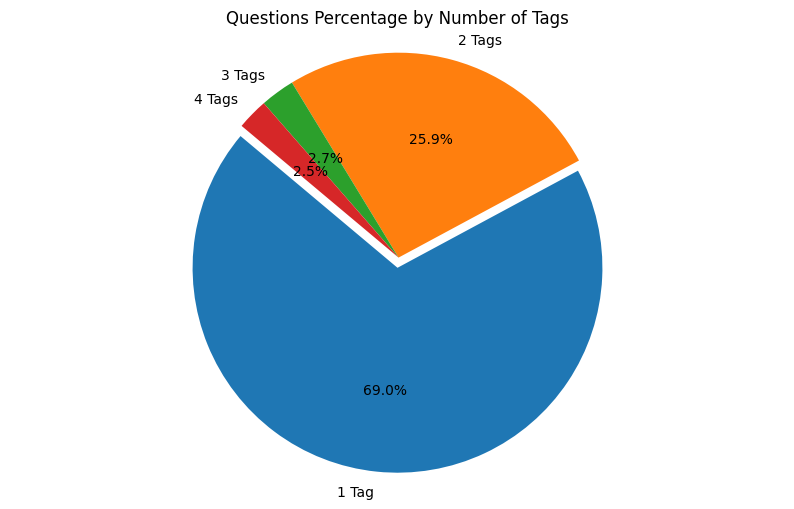

In [39]:
final_df['Num_Tags'] = final_df['Tag'].apply(lambda x: len(x))
final_df['Num_Words'] = final_df['Text'].apply(lambda x: len(x.split()))

tag_counts = (final_df['Num_Tags'].value_counts(normalize=True) * 100).sort_index().tolist()
labels = ['1 Tag', '2 Tags', '3 Tags', '4 Tags']
explode = (0.05, 0, 0, 0)

plt.figure(figsize=(10, 6))
plt.pie(tag_counts, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Questions Percentage by Number of Tags')
plt.axis('equal')
plt.show()

count    33374.000000
mean         1.386798
std          0.662912
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: Num_Tags, dtype: float64 



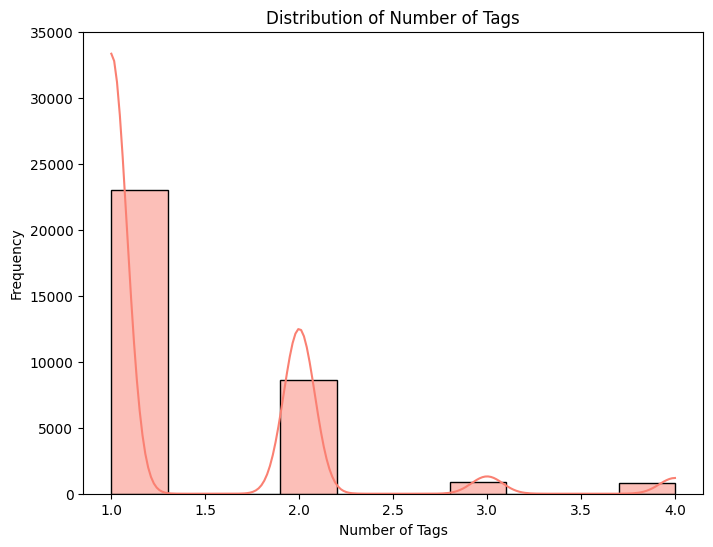

In [40]:
print(final_df['Num_Tags'].describe(),'\n')

plt.figure(figsize=(8, 6))
sns.histplot(final_df['Num_Tags'], bins=10, kde=True, color='salmon')
plt.title('Distribution of Number of Tags')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()

> We observe the most questions contain 1-2 tags and it is more rare to have more than 3 tags.

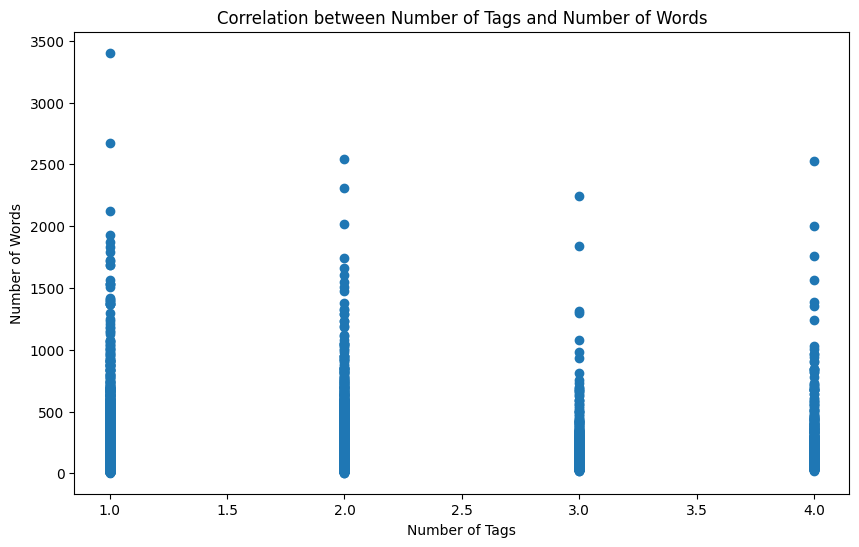

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['Num_Tags'], final_df['Num_Words'])
plt.title('Correlation between Number of Tags and Number of Words')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Words')
plt.show()

Statistics about the number of words in the 'Text' column:
count    33374.000000
mean       107.698478
std        119.354689
min          5.000000
25%         50.000000
50%         76.000000
75%        122.000000
max       3403.000000
Name: Num_Words, dtype: float64 



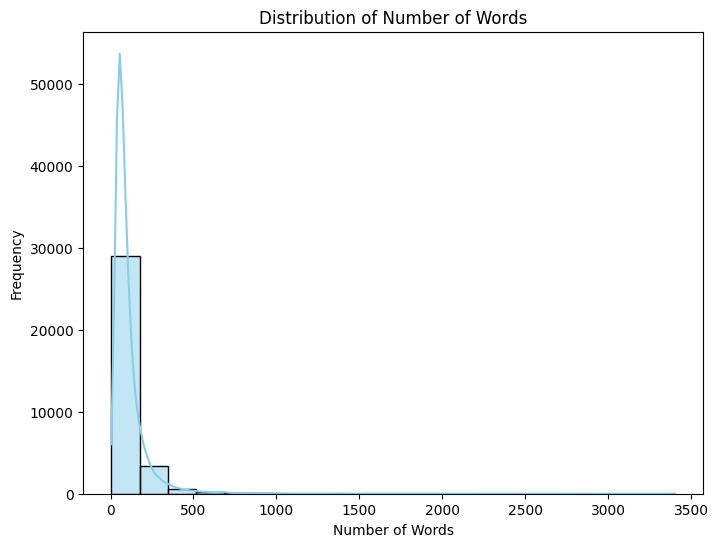

In [42]:
print("Statistics about the number of words in the 'Text' column:")
print(final_df['Num_Words'].describe(),'\n')

plt.figure(figsize=(8, 6))
sns.histplot(final_df['Num_Words'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

#### Prepare 'Tag' Column (Target)

> Because each of our Yi represents tags of a question and each Xi represents a question and a question in the Stack Overflow can have multiple tags, for that reason our possible data entries will have probably the following structure:
*   Q1 = {tag1,tag2}
*   Q2 = {tag2,tag3}
*   Q3 = {tag1,tag4}

> For example, a question on Stack Overflow might be about any of C++, Pointers, FileIO and/or memory-management at the same time or none of these.

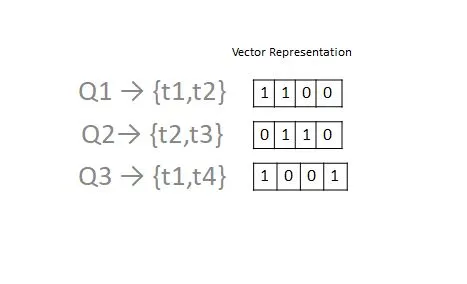

A concrete and clear example is showcased in the above figure, where **Binary Vector Representation** is introduced. For ease purposes, we are going to experiment with MultiLabelBinarizer from sklearn.

In [43]:
mlb = MultiLabelBinarizer(sparse_output=False)
tag_matrix = mlb.fit_transform(final_df['Tag'].tolist())
final_df['Target'] = tag_matrix.tolist()

print("Shape of tag matrix:", tag_matrix.shape)

Shape of tag matrix: (33374, 16)


> At this certain point, we faced RAM issues, session was constantly being crashed, due to the fact that array of size (1.264.216,5000) could not fit into memory. So this was the first sign to decrease either Tags or Questions or both.

> **Sparse Arrays**: The main idea behind sparse arrays is to store only the nonzero elements of a matrix, along with their indices, instead of storing the entire matrix. This approach saves memory and computational resources, especially when dealing with large datasets.

In [44]:
w = 10
print(final_df['Tag'].iloc[w])
tag_matrix[w]

['c++']


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Save dataframe to CSV

In [45]:
final_df.to_csv('/content/drive/MyDrive/Satori Assignment/data/preprocessed_data.csv', index=False)

print("Total time to run the notebook:", int((time.time()-start_time)/60), "minutes")

Total time to run the notebook: 11 minutes
